# BLP Sandbox 

In [1]:
import numpy as np 
import pandas as pd 
from scipy.linalg import block_diag
import seaborn as sns 
import matplotlib.pyplot as plt 

%load_ext autoreload 
%autoreload 2

%aimport logit

# Read in Verboven dataset

In [2]:
cars = pd.read_csv('cars.csv')

In [3]:
price_var = 'princ'

cars['logp'] = np.log(cars[price_var])

# new variable: price elasticity heterogeneous for home-region 
cars['logp_x_home'] = cars[price_var] * cars['home']

dummyvar = 'brd'
dummies = pd.get_dummies(cars[dummyvar])
x_vars_dummies = list(dummies.columns[1:].values) # omit a reference category §
if not dummies.columns[0] in cars.columns: 
    cars = pd.concat([cars,dummies], axis=1)
else: 
    print('dummies already in cars dataframe')

Set up an x matrix to do conditional logit.

In [4]:
x_vars = ['logp', 'home', 'cy', 'hp', 'we', 'li'] # + x_vars_dummies
print(f'K = {len(x_vars)} variables selected.')

K = len(x_vars)
N = cars.ma.nunique() * cars.ye.nunique()
J = 40 
x = cars[x_vars].values.reshape((N,J,K))
y = np.log(cars['s'].values.reshape((N,J))) # log market shares 

# standardize x
# x = ((x - x.mean(0).mean(0))/(x.std(0).std(0)))

K = 6 variables selected.


# Set up simple logit model

In [5]:
theta0 = np.zeros((K,))

In [6]:
ccp = logit.choice_prob(theta0, x)

In [7]:
def log_market_shares(delta): 
    assert delta.ndim == 2 
    N,J = delta.shape
    
    denom = np.log(np.sum(np.exp(delta), 1, keepdims=True)) # (N,1): keepdims ensures we can subtract from (N,J) array 
    
    return delta - denom

In [8]:
def ccp(delta): 
    assert delta.ndim == 2 
    
    ev = np.exp(delta - delta.max(1, keepdims=True))
    
    return ev / np.sum(ev, 1, keepdims=True)

The BLP contraction operator is 

$$ \delta^{r+1}_{ij} = f_{ij} (\delta^{r}) \equiv  \delta^{r}_{ij} + \log s^{data}_{ij} - \log s^{pred}_{ij}(\delta) $$ 

In [9]:
lms_data = y # observed log market shares
def contract(delta): 
    '''Take a single step in the BLP contraction'''
    assert delta.ndim == 2 
    N,J = delta.shape
    
    market_shares_pred = ccp(delta)
    
    # the contraction step 
    delta_new = delta + lms_data - np.log(market_shares_pred)
    
    # normalize one alternative in each choiceset 
    delta_new -= delta_new[:, 0].reshape(-1,1)
    
    return delta_new 

In [10]:
def fxp(delta0, f_contract=contract, maxit=100, tol=1e-12, DOPRINT=False): 
    '''fxp(): Solve the BLP Fixed Point by iterating on the contraction mapping'''
    assert callable(contract)
    N,J = delta0.shape
    
    crits = [] # return criterion values encountered along the way (for plotting)
    success = False 
    d0 = np.copy(delta0) 
    
    for it in range(maxit): 
        d1 = f_contract(d0) 

        crit = np.max(np.abs(d1 - d0))
        crits.append(crit)
        
        # check convergence 
        if crit < tol: 
            print(f'Convergence achieved at {it=}, {crit=: 8.4g}')
            success = True
            break
        else: 
            # update 
            if DOPRINT:  
                print(f'{it=:3d}: {crit=:8.4g}')
            d0 = d1
            
    return d1, success, crits 

In [11]:
delta0 = 1. + np.zeros((N,J))
delta_star = fxp(delta0)

Convergence achieved at it=1, crit= 1.776e-15


### Conclusion 

**Proposition:** Convergence occurs in a single iteration to $\delta_{ij}^* =  \log s^{data}_{ij}$. 

Convergence occurs in a single iteration on the contraction mapping. This is, however, not surprising if we look more closely at the operator: 

$$ f_{ij}(\delta) = \delta_{ij} + \log s^{data}_{ij} - \log s_{ij}(\delta)$$

Since the model is so simple, 
$$ 
\log s_{ij}(\delta) = \delta_{ij} - \log \left[ \sum_{k=1}^J \exp(\delta_{ik}) \right],
$$

implying that the contraction mapping simplifies to 
$$
f_{ij} (\delta) = \log s^{data}_{ij} - \log \left[ \sum_{k=1}^J \exp(\delta_{ik}) \right]. 
$$

And because the "logsum" is constant within a market $i$, we obtain 
$$
\delta_{ij}^* =  \log s^{data}_{ij}
$$

Note that the logsum here drops out because we do not have an outside option: we can scale up/down all $\delta_{ij}$ by the same additive level shift without affecting the choice probabilities (in fact, this is what we exploit when we do the max rescaling). Hence, only relative magnitudes matter, which are determined by $\log s^{data}_{ij}$. 

## Jacobian of the contraction mapping operator

Jacobian of the BLP contraction operator is 
$$
\frac{\partial f_{ij}}{\partial \delta_{k\ell}} = 1 - \frac{\partial \log s_{ij}(\delta)}{\partial \delta_{k\ell}}
$$

where 

$$ \frac{\partial s_{ij}}{\partial \delta_{k \ell}} = \begin{cases}
s_{ij}(1-s_{ij}) & i = k \wedge j = \ell, \\
- s_{ij} s_{i \ell} & i = k \wedge j \ne \ell, \\ 
0 & i \ne k.
\end{cases}$$ 

Since $\frac{\partial}{\partial \delta_{\ell m}} f_{ij}(\delta) = 0$ for $\ell \ne i$, and since `delta` is `(N,J)`, we have that co-dependence is only along rows. 

Note that the equations above should hold for general Mixed Logit, but not for nested logit (or so my intuition tells me). 

**visualizing** the block diagonal structure of the Jacobian matrix: run the code below
```python
J1 = block_diag(*[np.outer(delta1[i,:], delta1[i,:]) for i in range(3)])
sns.heatmap(-np.abs(J1), cmap='inferno')
```

Note: the code below assumes that we are vectorizing the whole thing, rather than looping over individual markets. The problem is incredibly sparse which is not exploited this way, and it is super inefficient with memory. But perhaps simpler to understand. 

In [12]:
def jac_contract(delta): 
    '''Jacobian of the contraction operator (for the stacked problem)
    Args
        delta: full list of mean utilities for all N*J market-product pairs 
    ''' 
    N,J = delta.shape 
    NJ = delta.size  # N*J
    
    # 1. compute CCPs 
    c = ccp(delta) 
    
    # 2. create -s_ij * s_ik 
    # since c is N*J, and since blocks only form within markets (i.e. rows), 
    # we just have to compute the outer product of each row, i=1,...,N
    J_common = block_diag(*[np.outer(c[i,:], c[i,:]) for i in range(N)])
    
    # 3. add s_ij to diagonal (keeping all other elements = -s_ij*s_ik 
    J_s = np.diag(c.flatten()) - J_common
    
    # 4. account for outer "delta + log()" 
    J_full = np.eye(NJ) - 1./(c.reshape(NJ,1)) * J_s
    
    return J_full

In [13]:
delta0 = 0.001 * np.ones((N,J))

In [14]:
Jac = jac_contract(delta0)

To check our calculations, it can be nice with a numerical derivative of the contraction operator.

In [15]:
def jac_contract_num(delta0, f_contract=contract, i=0, h=1e-8): 
    '''Numerical Jacobian (for just one row in the matrix)
    Args
        delta0: N*J matrix of mean utilities 
        f_contract: function handle to contraction operator 
        i: row at which to do the numerical jacobian 
        h: relative step size of the numerical derivative 
        
    Returns
        Jac_num: J-vector of partial effects of the contraction 
            mapping wrt. the deltas
    '''
    NJ = delta0.size
    assert callable(f_contract)
    
    d0 = f_contract(delta0)

    # compute step 
    delta1 = np.copy(delta0)
    if delta1[i,0] == 0.0: 
        delta1[i,0] = h
        step = h
    else: 
        delta1[i,0] = delta0[i,0]*(1.+h)
        step = h*delta0[i,0]

    # evaluate at d1 
    d1 = f_contract(delta1)

    # newton quotient 
    Jac_num = (d1 - d0)/step

    Jac_num = Jac_num.reshape(1, NJ)
    
    return Jac_num

In [16]:
delta0 = 1. + np.zeros((N,J))

In [17]:
i=0
np.mean(np.abs(jac_contract_num(delta0, contract, i) - jac_contract(delta0)[i,:]))

0.00016666666666666666

In [18]:
jac_contract_num(delta0, contract, i)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [19]:
jac_contract(delta0)[i,:]

array([0.025, 0.025, 0.025, ..., 0.   , 0.   , 0.   ])

# More complex logit models

Once we introduce either *Random Coefficients* or *Nesting* in the logit model, however, the fixed point problem becomes non-trivial. This is because $\delta_{ij} - \log s_{ij}(\delta)$ is no longer constant across $j$ within $i$. 

In this example, suppose that $\theta_{k} \sim F$ according to some cdf $F$. And either we are calculating an approximation of the final integral using $\theta_{ks}$ for $s = 1,...,10$ grid points, or else we are really assuming a latent class model where there are only $S = 10$ possible values that $\theta_k$ can take.

In [20]:
S = 10 # "simulations" 
thetas = .1 + np.zeros((S,K))

k = 0 
thetas[:, k] += np.linspace(-.3, .3, S)

In [21]:
def ccp_s(delta, x_demean, theta): 
    '''ccp_s: conditional choice probabilities for a specific vector of thetas'''
    assert theta.ndim == 1
    N,J,K = x_demean.shape
    K = theta.shape 
    
    mu = x_demean @ theta # -> (N,J)
    v = delta + mu
    vmax = v.max(1, keepdims=True) # (N,1), not (N,): so we can subtract column-wise from an (N,J) matrix
    ev = np.exp(v - vmax)
    denom = np.sum(ev, 1, keepdims=True) # (N,1) for same reasons
    return ev / denom 

def ccp_full(delta, x_demean, thetas): 
    '''ccp_full: integrate out S draws of theta''' 
    N,J = delta.shape
    S,K = thetas.shape
    
    c = np.zeros((N,J))
    for s in range(S): # iterate over simulated theta vectors 
        prob = 1/S # uniform weights, e.g. in Monte Carlo simulation 
        c += prob * ccp_s(delta, x_demean, thetas[s,:])
    
    return c 

In [22]:
x_demean = (x - x.mean(0).mean(0).reshape(1,1,K)) / (x.std(0).std(0).reshape(1,1,K))

In [23]:
delta0 = np.copy(y) # starting value: mean utils from a simple logit 
lms_data = y # observed log market shares
def contract(delta, DONORMALIZE=True): 
    '''Take a single step in the BLP contraction'''
    assert delta.ndim == 2 
    N,J = delta.shape
    
    #lms_pred = log_market_shares(delta)
    market_shares_pred = ccp_full(delta, x_demean, thetas)
    
    delta_new = delta + lms_data - np.log(market_shares_pred)
    
    # normalize one delta for each choiceset 
    if DONORMALIZE: 
        delta_new -= delta_new[:, 0].reshape(-1,1)
    
    return delta_new

In [24]:
def fxp(delta0, f_contract=contract, maxit=100, tol=1e-12, DOPRINT=False): 
    assert callable(contract)
    N,J = delta0.shape
    
    crits = [] 
    success = False 
    d0 = np.copy(delta0) 
    
    for it in range(maxit): 
        d1 = f_contract(d0) 

        crit = np.max(np.abs(d1 - d0))
        crits.append(crit)
        
        # check convergence 
        if crit < tol: 
            print(f'Convergence achieved at {it=}, {crit=: 8.4g}')
            success = True
            break
        else: 
            # update 
            if DOPRINT:  
                print(f'{it=:3d}: {crit=:8.4g}')
            d0 = d1
            
    return d1, success, crits 

In [25]:
delta0 = np.zeros((N,J))
delta_star, success, crits = fxp(delta0, f_contract=contract, maxit=100)

Convergence achieved at it=67, crit= 7.55e-13


Plotting convergence of the criterion by successive approximations.

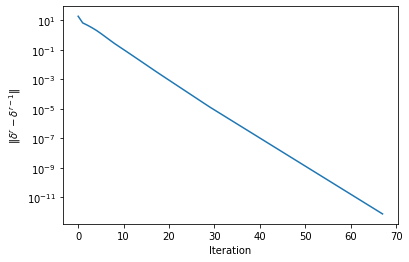

In [26]:
fig,ax = plt.subplots()
ax.plot(crits)
ax.set_yscale('log');
ax.set_ylabel('$\\Vert \delta^{r} - \delta^{r-1} \\Vert$')
ax.set_xlabel('Iteration'); 

## Jacobian 

***Work in progress below*** There's a bug in the code below. Fix it! :)

In [27]:
def jac_contract(delta, DONORMALIZE=True): 
    '''Jacobian of the contraction operator''' 
    N,J = delta.shape 
    NJ = delta.size    
    

    J_s_tot = np.zeros((NJ,NJ)) 
    J_common = np.zeros((NJ,NJ))
    
    for s in range(S): 

        # 1. compute CCPs 
        c = ccp_s(delta, x_demean, thetas[s,:]) 
        
        # 2. create -s_ij * s_ik 
        # since c is N*J, and since blocks only form within markets (i.e. rows), 
        # we just have to compute the outer product of each row, i=1,...,N
        #J_common = block_diag(*[np.outer(c[i,:], c[i,:]) for i in range(N)])
        
        # reset the entire diagonal (zeros outside are untouched)
        for i in range(N): 
            idx = slice(i*J, i*J+J)
            J_common[idx, idx] = np.outer(c[i,:], c[i,:])

        # 3. add s_ij to diagonal (keeping all other elements = -s_ij*s_ik 
        J_s = np.diag(c.flatten()) - J_common
        
        J_s_tot += J_s / S

    # compute CCPs 
    c = ccp_full(delta, x_demean, thetas) 
    # account for outer "delta + log()" 
    J_full = np.eye(NJ) - 1./(c.reshape(NJ,1)) * J_s_tot
    
    # there are N blocks of (J,J)
    if DONORMALIZE: 
        for i in range(N): 
            idx = slice(J*i, J*i+J) # the rows/cols of block i 
            J0_i = J_full[idx, J*i].reshape(J, 1)
            J_full[idx,idx] -= J0_i
    
    return J_full 

def jac_contract_num(delta0, f_contract=contract, i=0, j=0, h=1e-8, DONORMALIZE=True): 
    '''Numerical Jacobian (one row in the matrix)'''
    NJ = delta0.size
    assert callable(f_contract)
    
    d0 = f_contract(delta0, DONORMALIZE)

    # compute step 
    delta1 = np.copy(delta0)
    if delta1[i,j] == 0.0: 
        delta1[i,j] = h
        step = h
    else: 
        delta1[i,j] = delta0[i,j]*(1.+h)
        step = h*delta0[i,j]

    # evaluate at d1 
    d1 = f_contract(delta1, DONORMALIZE)

    # newton quotient 
    Jac_num = (d1 - d0)/step

    Jac_num = Jac_num.reshape(1, NJ)
    
    return Jac_num

In [28]:
d0 = np.zeros((N,J))

In [29]:
i=1
j=0
DON = False
JA = jac_contract(d0, DONORMALIZE=DON)
JN = jac_contract_num(d0, contract, i, j, DONORMALIZE=DON)
JAvec = JA[i*J +j, i*J:-1]
JNvec = JN[0, i*J:-1]

pd.DataFrame({'Anal':JAvec, 'Num':JNvec}) # <- these should give identical numbers

,Anal,Num
0,0.000061,0.000061
1,0.000983,0.000030
2,0.000045,0.000059
3,0.001373,0.000046
4,0.001873,0.000050
...,...,...
5954,0.000000,0.000000
5955,0.000000,0.000000
5956,0.000000,0.000000
5957,0.000000,0.000000


In [30]:
i=0
assert np.mean(np.abs((jac_contract(delta_star)[i, :] - jac_contract_num(delta_star, contract, i)))) < 1e-8, \
    f'Some error remains in the Jacobian'

AssertionError: Some error remains in the Jacobian

**Status:** I'm pretty sure that my suffering is because of the normalization of one of my delta coefficients. I've created my FXP so that it iterates on a full list of deltas even though some of them are later killed :/ I'm subtracting `delta[:, 0]`, i.e. doing $\delta_{ij} -= \delta_{i1}$ for all $j$ (also meaning that $\delta_{i1} = 0.0$ always). The Jacobian thus must have zero partial effect for the first entry, which it does. But the others do not align, somehow. 